# General Notebook on fine-tuning branch point prediction using any of MultiMolecule models

Any RNA model can be selected from the [MultiMolecule](https://multimolecule.danling.org/models/) website. Simple change the `MULTIMOLECULE_MODEL` variable in the cell below, and the the two cells under the tokenizer "Load the desired model and tokenizer" section.

In [14]:
# GLOBAL VARIABLES
WORKING_DIRECTORY = '/content/drive/MyDrive/epfl_ml_project'
DATASET_PATH = 'data/fresh_dataset.txt'
MODEL_MAX_INPUT_SIZE = 511
MULTIMOLECULE_MODEL = "rnaernie"
SAMPLE_N_DATAPOINTS = 30000 # Sample a small subset of data for testing purposes. Set to None if training on full dataset
SEED = 32

In [15]:
%%capture
!pip install datasets evaluate multimolecule==0.0.5

In [16]:
import pandas as pd
import torch
from transformers import (
     DataCollatorForTokenClassification,
     TrainingArguments,
     Trainer
)

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [18]:
from google.colab import drive
drive.mount('/content/drive')

# Change working directory to Project folder, you may change this as needed
%cd {WORKING_DIRECTORY}

from BP_LM.scripts.data_preprocessing import *
from BP_LM.scripts.trainer_datasets_creation import *
from BP_LM.scripts.compute_metrics import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/epfl_ml_project


## Load the desired model and tokenizer

In [19]:
# Change this import depending on the model
from multimolecule import RnaTokenizer, RnaErnieForTokenPrediction, RnaErnieConfig

tokenizer = RnaTokenizer.from_pretrained(f'multimolecule/{MULTIMOLECULE_MODEL}')
# Change line below depending on what model we want
config = RnaErnieConfig()
config.problem_type = "single_label_classification"
config.num_labels = 2
model = RnaErnieForTokenPrediction.from_pretrained(f'multimolecule/{MULTIMOLECULE_MODEL}', config=config)

Some weights of RnaErnieForTokenPrediction were not initialized from the model checkpoint at multimolecule/rnaernie and are newly initialized: ['rnaernie.splicebert.embeddings.layer_norm.bias', 'rnaernie.splicebert.embeddings.layer_norm.weight', 'rnaernie.splicebert.embeddings.position_embeddings.weight', 'rnaernie.splicebert.embeddings.token_type_embeddings.weight', 'rnaernie.splicebert.embeddings.word_embeddings.weight', 'rnaernie.splicebert.encoder.layer.0.attention.output.dense.bias', 'rnaernie.splicebert.encoder.layer.0.attention.output.dense.weight', 'rnaernie.splicebert.encoder.layer.0.attention.output.layer_norm.bias', 'rnaernie.splicebert.encoder.layer.0.attention.output.layer_norm.weight', 'rnaernie.splicebert.encoder.layer.0.attention.self.key.bias', 'rnaernie.splicebert.encoder.layer.0.attention.self.key.weight', 'rnaernie.splicebert.encoder.layer.0.attention.self.query.bias', 'rnaernie.splicebert.encoder.layer.0.attention.self.query.weight', 'rnaernie.splicebert.encoder.la

In [20]:
# Set up the collator
data_collator = DataCollatorForTokenClassification(tokenizer)

## Create dataset objects for training

In [21]:
# Load dataset
df = pd.read_csv(DATASET_PATH, sep='\t')

train_dataset, val_dataset, test_dataset = create_dataset(df, tokenizer, model, MODEL_MAX_INPUT_SIZE, SEED, SAMPLE_N_DATAPOINTS)

Chromosomes in train set: {'chrY', 'chr13', 'chr1', 'chr22', 'chr20', 'chr21', 'chr12', 'chrX', 'chr17', 'chr14', 'chr7', 'chr19', 'chr5', 'chr16', 'chr15', 'chr6', 'chr4', 'chr18', 'chr2', 'chr3'}
Chromosomes in validation set: {'chr9', 'chr10'}
Chromosomes in test set: {'chr8', 'chr11'}

Total data points: 30000
Train set contains 24871 data points (82.90%)
Validation set contains 2393 data points (7.98%)
Test set contains 2736 data points (9.12%)


## Train model

In [22]:
# Do not save to W&B
import os
os.environ["WANDB_MODE"] = "disabled"

In [23]:
# Define model training parameters
batch_size = 16

args = TrainingArguments(
    f"multimolecule-{MULTIMOLECULE_MODEL}-finetuned-secondary-structure",
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=10000,
    learning_rate=3e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    optim = "adamw_torch",
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="F1",
)

<ipython-input-24-1f8e7890bbfe>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,F1,Seq. acc.,Ap,Mcc,Auc,Ideal Threshold
500,0.019300,0.015610,0.004406,0.000000,0.002204,0.000465,0.501323,0.001957
1000,0.016100,0.015617,0.007061,0.000000,0.002443,0.001480,0.500753,0.001906
1500,0.016100,0.015682,0.009191,0.000000,0.002447,0.000969,0.500130,0.001636


/content/drive/MyDrive/epfl_ml_project/BP_LM/scripts/compute_metrics.py:55: RuntimeWarning: invalid value encountered in divide
  ideal_threshold = thresholds[np.nanargmax(2 * (precision * recall) / (precision + recall))]
/content/drive/MyDrive/epfl_ml_project/BP_LM/scripts/compute_metrics.py:56: RuntimeWarning: invalid value encountered in divide
  F1 = np.nanmax(2 * (precision * recall) / (precision + recall))
/content/drive/MyDrive/epfl_ml_project/BP_LM/scripts/compute_metrics.py:55: RuntimeWarning: invalid value encountered in divide
  ideal_threshold = thresholds[np.nanargmax(2 * (precision * recall) / (precision + recall))]
/content/drive/MyDrive/epfl_ml_project/BP_LM/scripts/compute_metrics.py:56: RuntimeWarning: invalid value encountered in divide
  F1 = np.nanmax(2 * (precision * recall) / (precision + recall))


TrainOutput(global_step=1555, training_loss=0.017164802742924336, metrics={'train_runtime': 657.6299, 'train_samples_per_second': 37.819, 'train_steps_per_second': 2.365, 'total_flos': 6556615985705940.0, 'train_loss': 0.017164802742924336, 'epoch': 1.0})

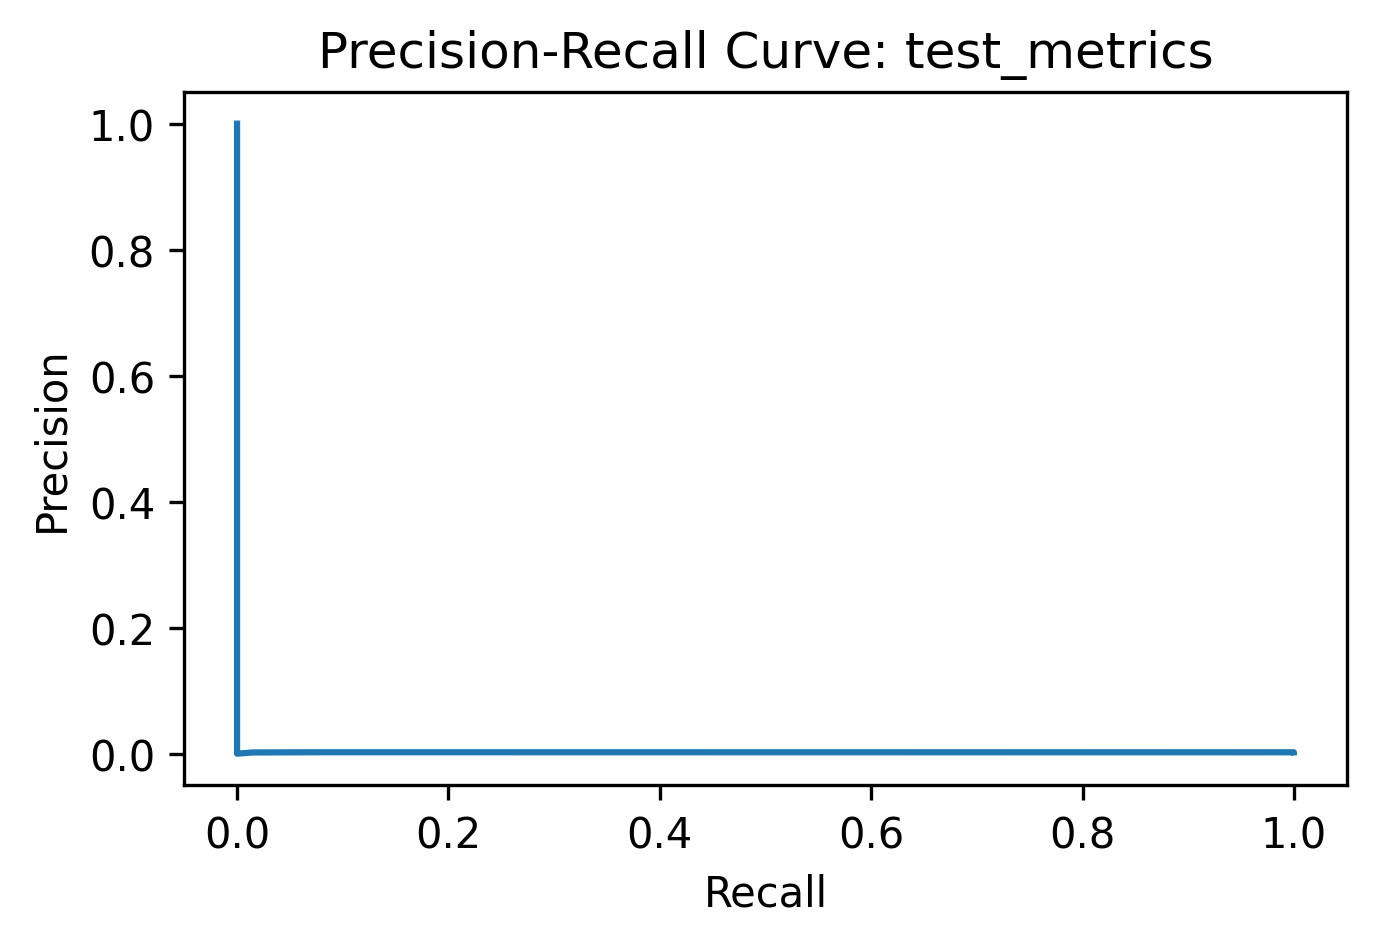

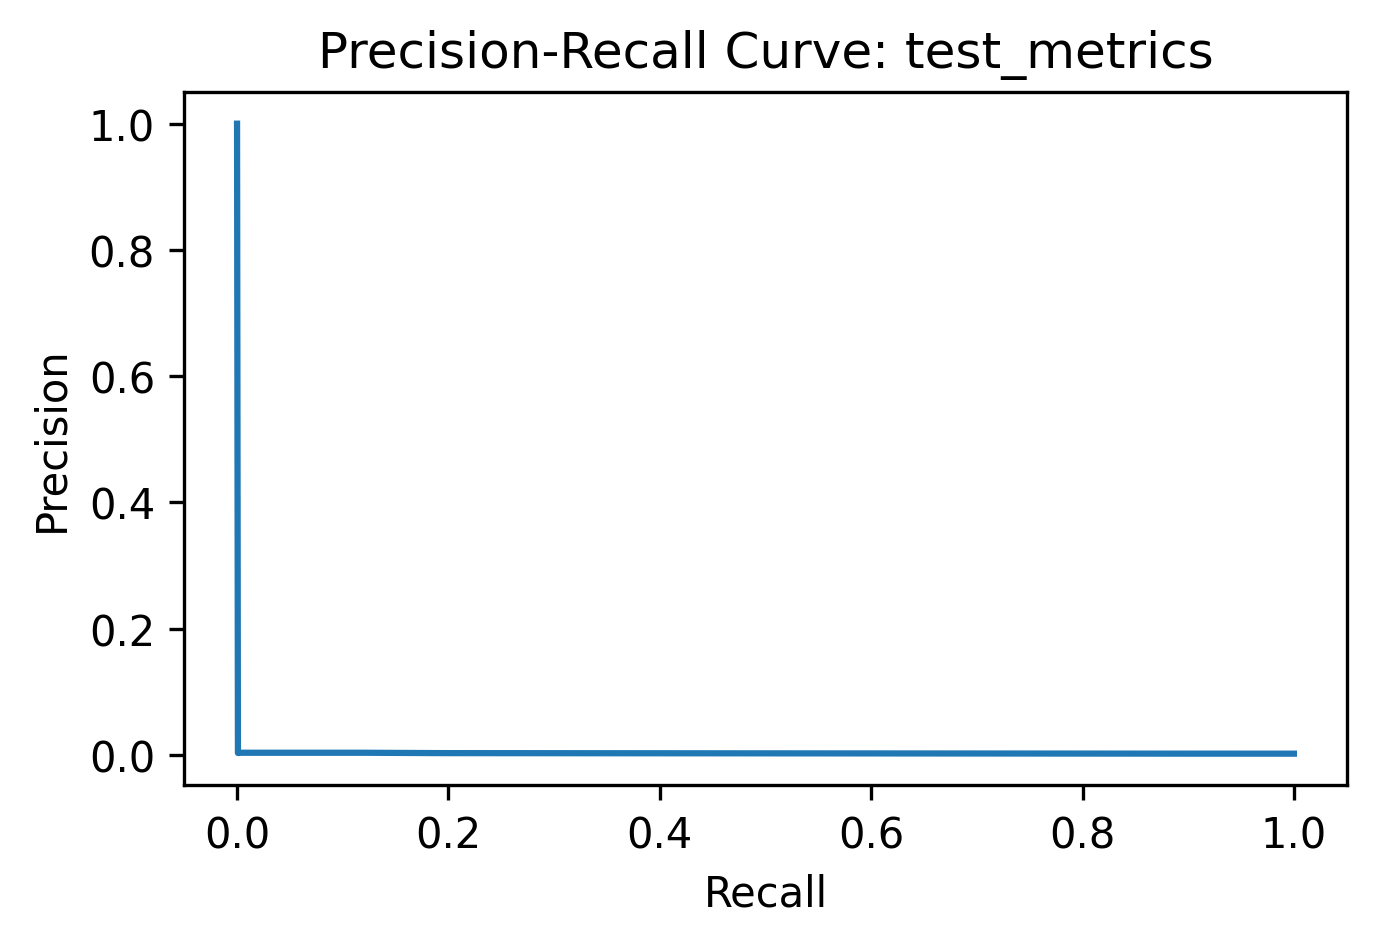

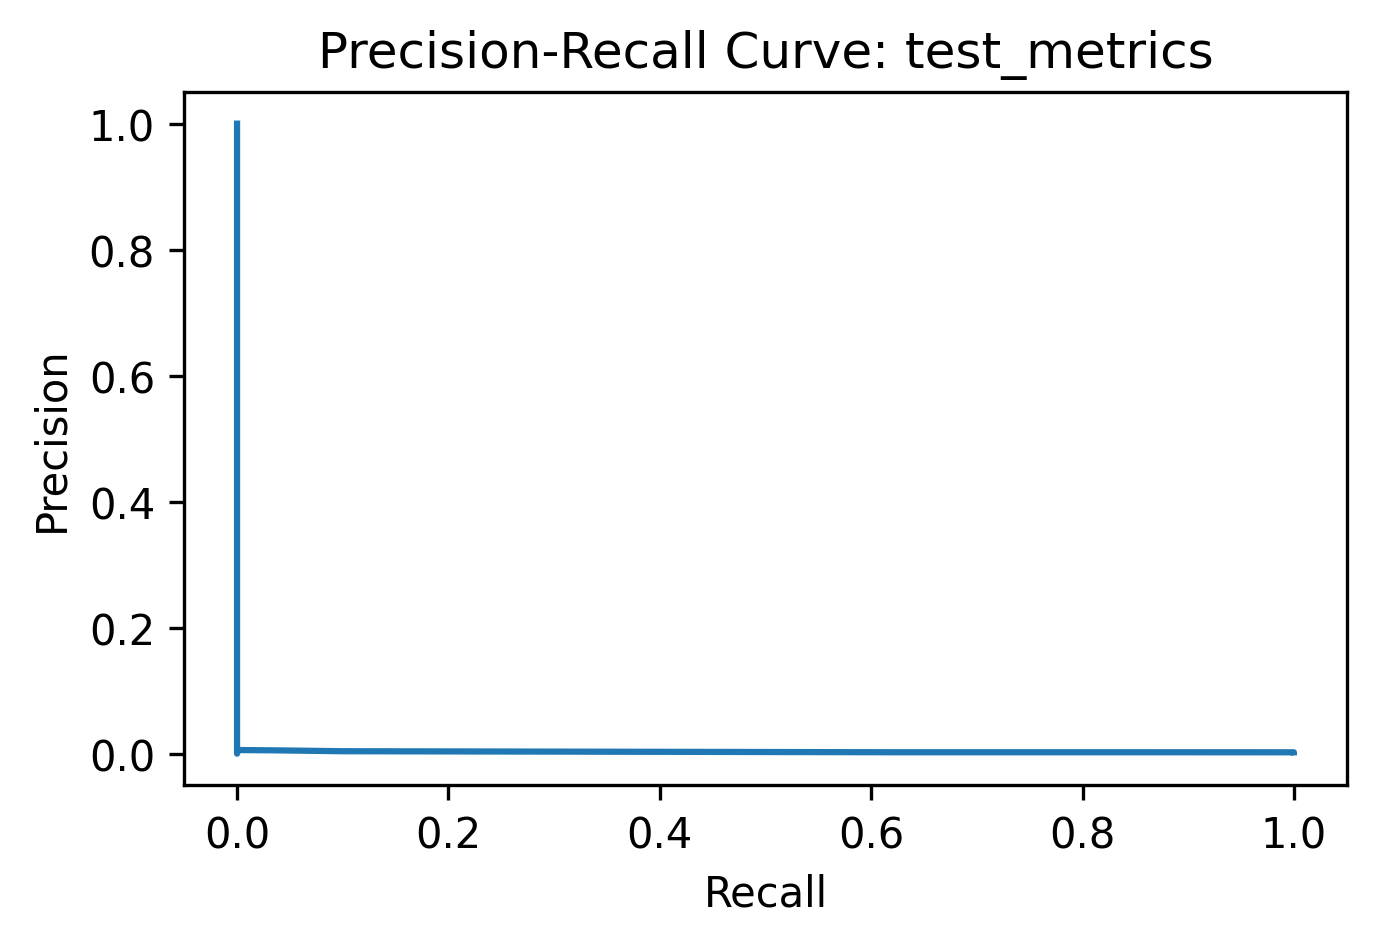

In [24]:
metrics = lambda x: compute_metrics(x, "test_metrics")
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


In [25]:
trained_model = AutoModelForTokenClassification.from_pretrained(f"multimolecule-{MULTIMOLECULE_MODEL}-finetuned-secondary-structure/checkpoint-777") #make sure you are loading the right checkpoint
tokenizer = AutoTokenizer.from_pretrained(f"multimolecule-{MULTIMOLECULE_MODEL}-finetuned-secondary-structure/checkpoint-777")
data_collator = DataCollatorForTokenClassification(tokenizer)

NameError: name 'AutoModelForTokenClassification' is not defined

In [ ]:
metric = lambda x: compute_metrics_test(x, "test_metrics", 0.001895)

testing_args = TrainingArguments(
    output_dir='/results',
    per_device_eval_batch_size=batch_size,
    do_eval=True,
    no_cuda=False,
)

tester = Trainer(
    model=trained_model,
    args=testing_args,
    eval_dataset=test_dataset,
    compute_metrics=metric,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

metrics = tester.evaluate()

print("Evaluation Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value}")